# Visualization of training and test curves with different optimizers
This notebook is modified from https://github.com/Luolc/AdaBound/blob/master/demos/cifar10/visualization.ipynb.
We compare the performace of AdaBelief optimizer and 8 other optimizers (SGDM, AdaBound, Yogi, Adam, MSVAG, RAdam, AdamW, Fromage).
The training setting is the same as the official implementation of AdaBound: https://github.com/Luolc/AdaBound,
hence we exactly reproduce the results of AdaBound.
AdaBound is claimed to achieve "fast convergence and good generalization", and in this project we will show that AdaBelief outperforms AdaBound and other optimizers.

In [1]:
import os
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy as np

params = {'axes.labelsize': 20,
          'axes.titlesize': 20,
         }
plt.rcParams.update(params)

In [52]:
def get_data(names):
    folder_path = './probecurve'
    paths = [os.path.join(folder_path, name) for name in names]
    return {name: torch.load(fp) for name, fp in zip(names, paths)}

def plot(names, curve_type='train', labels = None, ylim=(80,101), loc = 'upper left'):
    plt.figure()
    plt.ylim(ylim)# if curve_type == 'train' else 96)
    curve_data = get_data(names)
    for i, label in zip(curve_data.keys(),labels):
        acc = np.array(curve_data[i]['{}_acc'.format(curve_type.lower())])
        if label == 'AdaBelief':
            plt.plot(acc, '-', label=label)
        else:
            plt.plot(acc, '--',label = label)
    
    plt.grid()
    plt.legend(fontsize=14, loc=loc)
    #plt.title('{} accuracy ~ Training epoch'.format(curve_type))
    plt.xlabel('Training Epoch')
    plt.ylabel(curve_type + ' Accuracy')
    plt.xlim([0, 200])
    plt.tight_layout()
    plt.show()

In [20]:
#data = torch.load('./probecurve/resnet-sgd-lr0.1-momentum0.9-wdecay0.0005-run0-resetFalse')
#data = torch.load('./probecurve/resnet-cap-lr0.1-momentum0.9-wdecay0.0005-run0-resetFalse')
#data = torch.load('./probecurve/resnet-abcapi-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-02')
#data = torch.load('./probecurve/resnet-abcapi-cl100-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-00')
# data = torch.load('./probecurve/resnet-abcapi-cl100-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-de60-00')
#data = torch.load('./probecurve/resnet-abcapi-cl10-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-de60-00')
#data = torch.load('./probecurve/resnet-abcapi-cl10-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-caprate')
data = torch.load('./probecurve/resnet-abcapi-cl10-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-de60-dep')
#data = torch.load('./probecurve/resnet-abcapi-cl10-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-ind')
#data = torch.load('./curve/resnet-adabelief-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse')

buf
loss <= 0 False
ratio <= 0 True
ratio < 1 6336
|ratio < 1| 0.7194643036464383


<IPython.core.display.Javascript object>


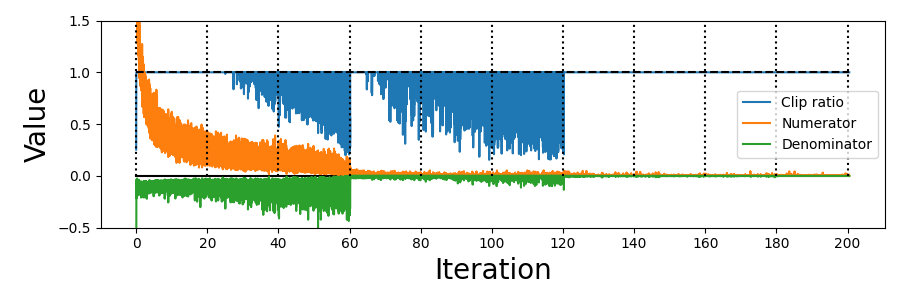

In [44]:
newton_cap_logs = [d for log in data["nc_logs"] for d in log]
zipped = tuple(zip(*newton_cap_logs))
if len(zipped) == 4: delt_sqnorm, grad_sqnorm, delt_dot_grad, loss = zipped
else:
    delt_sqnorm, grad_sqnorm, delt_dot_grad, _, loss = zipped # buffered loss
    #loss = [l if l is not None else 0 for l in loss]    
    print("buf")
delt_sqnorm = np.array(delt_sqnorm)
grad_sqnorm = np.array(grad_sqnorm)
delt_dot_grad = np.array(delt_dot_grad)
loss = np.array(loss)

idx = np.flatnonzero(loss == None)
loss[idx] = loss[idx+1]
print("loss <= 0", (loss <= 0).any())

dg_ang = delt_dot_grad / (delt_sqnorm**.5 * grad_sqnorm**.5)
newton_ratio = - loss / delt_dot_grad
#newton_cap = newton_ratio * ((0 < newton_ratio) & (newton_ratio < 1)).astype(float)
#newton_cap = np.maximum(0., np.minimum(1., newton_ratio))
newton_cap = np.where((0 < newton_ratio) & (newton_ratio < 1), newton_ratio, 1) # outside (0,1), acts like scale by 1
print("ratio <= 0", (newton_ratio <= 0).any())
print("ratio < 1", ((0 < newton_ratio) & (newton_ratio < 1)).sum())
print("|ratio < 1|", newton_ratio[(0 < newton_ratio) & (newton_ratio < 1)].mean())
# w = 800
# loss = np.convolve(loss, np.ones(w), 'valid')/w
# delt_dot_grad = np.convolve(delt_dot_grad, np.ones(w), 'valid')/w
# newton_cap = np.convolve(newton_cap, np.ones(w), 'valid')/w

qtys = {
    "ddg": delt_dot_grad,
    "dn": -delt_sqnorm,
    "loss": loss,
    "ang": dg_ang,
    "nr": newton_ratio,
    "nc": newton_cap,
}

# gradnorm doesn't get smaller after lr adjust
# at the end, cap is highly correlated with dtg (dtg dependence version)
# at the end, angle between d and g gets bigger on average (dtg dependence version)

plt.close()
plt.figure(figsize=(9,3))
keys = ["nc","loss","ddg"]
for k in keys:
    plt.plot(np.array(qtys[k]))
#plt.legend(keys,loc='lower right')
plt.legend(["Clip ratio", "Numerator", "Denominator"], loc='center right')
bars = np.arange(0,len(loss),390*20)
for b in bars:
    #plt.plot([b,b],[-1,5],'k:')
    plt.plot([b,b],[0, max([np.max(v) for v in qtys.values()])],'k:')
    #plt.text(b,-.5,str(int(b/390)))
if "nr" in qtys.keys(): plt.plot([0,len(loss)],[1,1],'k--')
plt.plot([0, len(loss)], [0,0], 'k-', zorder=-1)
#plt.ylim([0, .25])
#plt.xlim([50000,90500])
#plt.xlim([0, len(loss)])
plt.xticks(bars, map(str, (bars/390).astype(int)))
plt.xlabel("Iteration")
plt.ylim([-.5, 1.5])
plt.ylabel("Value")
plt.tight_layout()
plt.show()

# ResNet
Plot the training and test curves for all optimizers in one plot. "names" is a list containing the log files in "/curve" folder, "labels" is the corresponding legends for different optimizers. Note that "names" and "labels" must match (log for the i-th element in "labels" in the i-th element in "names")

<IPython.core.display.Javascript object>


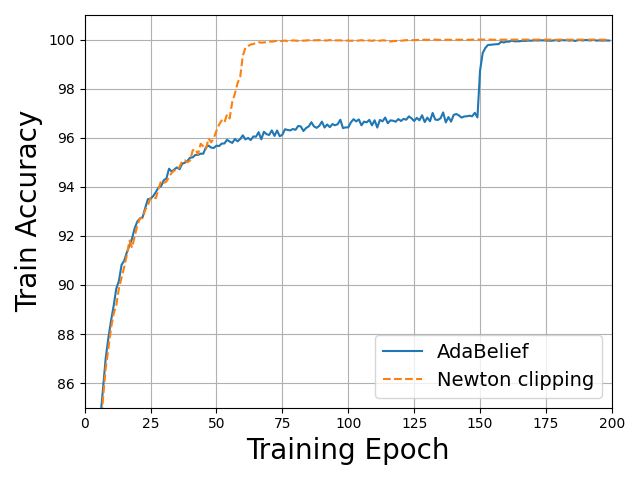

<IPython.core.display.Javascript object>


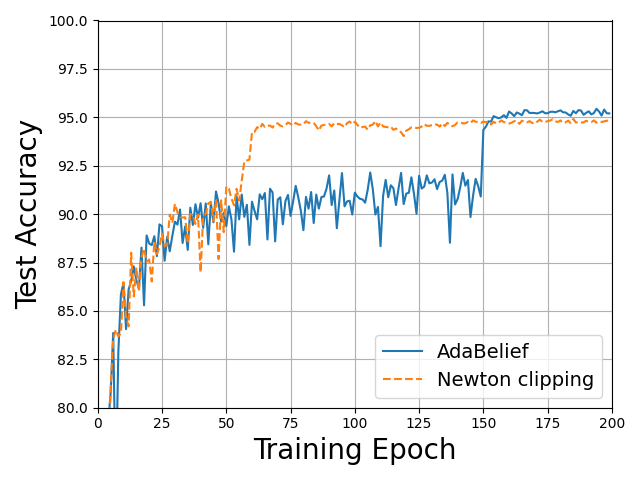

In [53]:
names = [
        'resnet-adabelief-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-00',
#         'resnet-adabelief-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-01',
#         'resnet-adabelief-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-02',
#         'resnet-adabelief-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-03',
#         'resnet-adabelief-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-04',
#          'resnet-abcapi-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-00',
#          'resnet-abcapi-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-01',
#          'resnet-abcapi-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-02',
#        'resnet-abcapi-cl100-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-00',
#        'resnet-abcapi-cl100-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-01',
#        'resnet-abcapi-cl100-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-02',
#        'resnet-abcapi-cl100-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-de60-00',
#        'resnet-abcapi-cl10-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-de60-00',
#         'resnet-abcapi-cl10-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-ind',
#         'resnet-abcapi-cl10-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-caprate',
    'resnet-abcapi-cl10-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-de60-dep',
          #'resnet-abcap-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-00',
          #'resnet-abcap-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-01',
          #'resnet-abcap-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse-02',
#          'resnet-sgd-lr0.1-momentum0.9-wdecay0.0005-run0-resetFalse',
#           'resnet-cap-lr0.1-momentum0.9-wdecay0.0005-run0-resetFalse',
#          'resnet-adabound-lr0.001-betas0.9-0.999-final_lr0.1-gamma0.001-wdecay0.0005-run0-resetFalse',
#          'resnet-yogi-lr0.001-betas0.9-0.999-eps0.001-wdecay0.0005-run0-resetFalse',
#          'resnet-adam-lr0.001-betas0.9-0.999-wdecay0.0005-eps1e-08-run0-resetFalse',
#          'resnet-msvag-lr0.1-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse',
#          'resnet-radam-lr0.001-betas0.9-0.999-wdecay0.0005-eps1e-08-run0-resetFalse',
#          'resnet-adamw-lr0.001-betas0.9-0.999-wdecay0.01-eps1e-08-run0-resetFalse',
#          'resnet-fromage-lr0.01-betas0.9-0.999-wdecay0.0005-eps1e-08-run0-resetFalse',
]
labels = [
          'AdaBelief',
#           'AdaBelief',
#           'AdaBelief',
#           'AdaBelief',
#           'AdaBelief',
#           'abcapi-00',
#           'abcapi-01',
#           'abcapi-02',
#           'abcapi-00-cl100',
#           'abcapi-01-cl100',
#           'abcapi-02-cl100',
#           'abcapi-cl100-de60',
#           'abcapi-cl10-ind',
#           'abcapi-caprate',
    'Newton clipping',
           #'abcap-00',
           #'abcap-01',
           #'abcap-02',
#           'SGD',
#           'cap'
#           'AdaBound',
#           'Yogi',
#           'Adam',
#           'MSVAG',
#           'RAdam',
#           'AdamW',
#           'Fromage',
        ]
plot(names, 'Train', labels, ylim = (85, 101), loc="lower right")
plot(names, 'Test', labels, ylim = (80,100), loc="lower right") 
#plot(names, 'Test', labels, ylim = (0,96))     

In [ ]:
# DenseNet

<IPython.core.display.Javascript object>


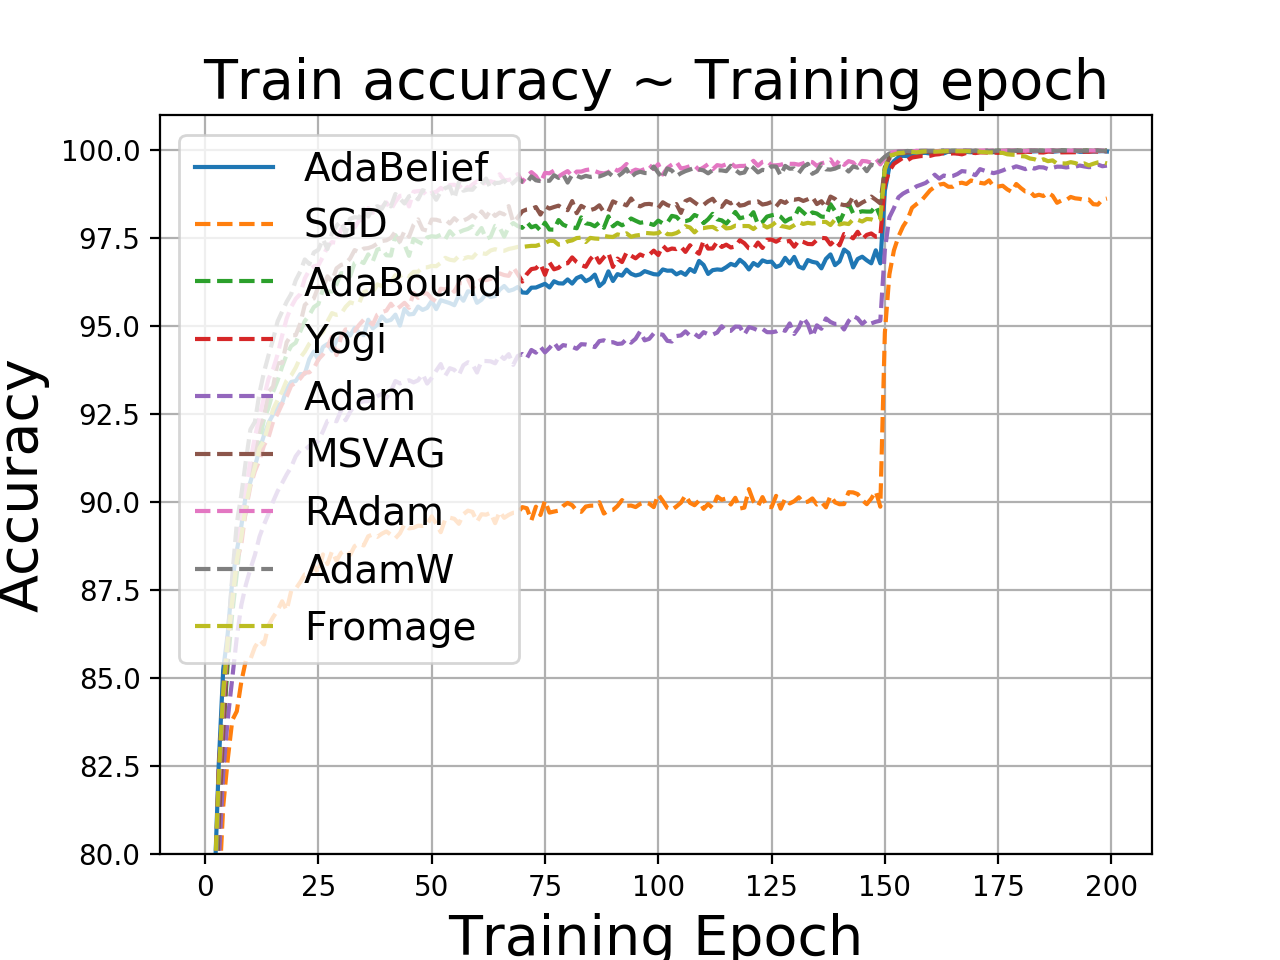

<IPython.core.display.Javascript object>


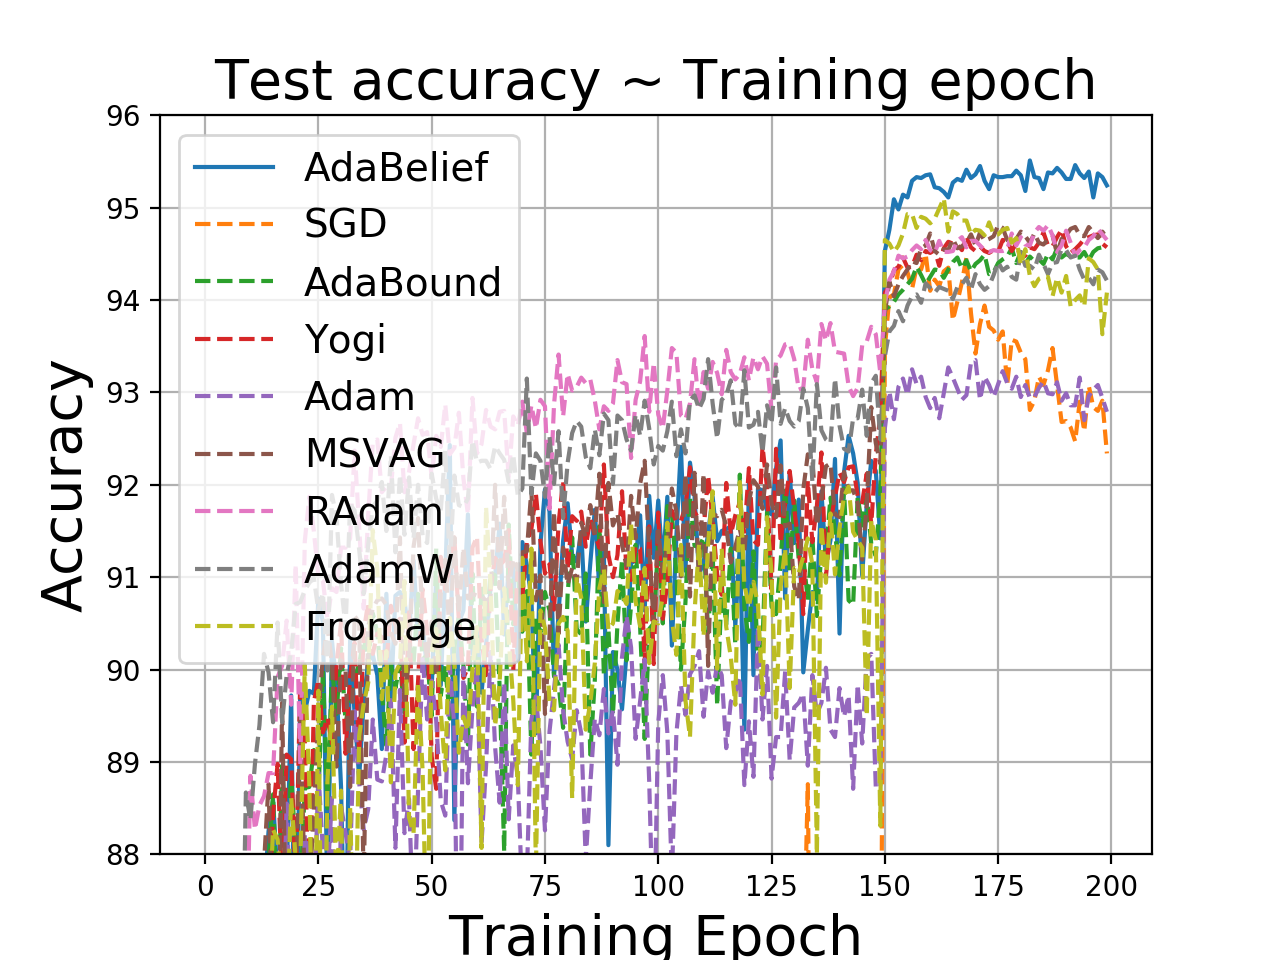

In [8]:
names = ['densenet-adabelief-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse',
         'densenet-sgd-lr0.1-momentum0.9-wdecay0.0005-run0-resetFalse',
         'densenet-adabound-lr0.001-betas0.9-0.999-final_lr0.1-gamma0.001-wdecay0.0005-run0-resetFalse',
         'densenet-yogi-lr0.001-betas0.9-0.999-eps0.001-wdecay0.0005-run0-resetFalse',
         'densenet-adam-lr0.001-betas0.9-0.999-wdecay0.0005-eps1e-08-run0-resetFalse',
         'densenet-msvag-lr0.1-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse',
         'densenet-radam-lr0.001-betas0.9-0.999-wdecay0.0005-eps1e-08-run0-resetFalse',
         'densenet-adamw-lr0.001-betas0.9-0.999-wdecay0.01-eps1e-08-run0-resetFalse',
         'densenet-fromage-lr0.01-betas0.9-0.999-wdecay0.0005-eps1e-08-run0-resetFalse',
]
labels = ['AdaBelief',
          'SGD',
          'AdaBound',
          'Yogi',
          'Adam',
          'MSVAG',
          'RAdam',
          'AdamW',
          'Fromage',
        ]
plot(names, 'Train', labels)
plot(names, 'Test', labels, ylim = (88,96))     

## VGG Network

<IPython.core.display.Javascript object>


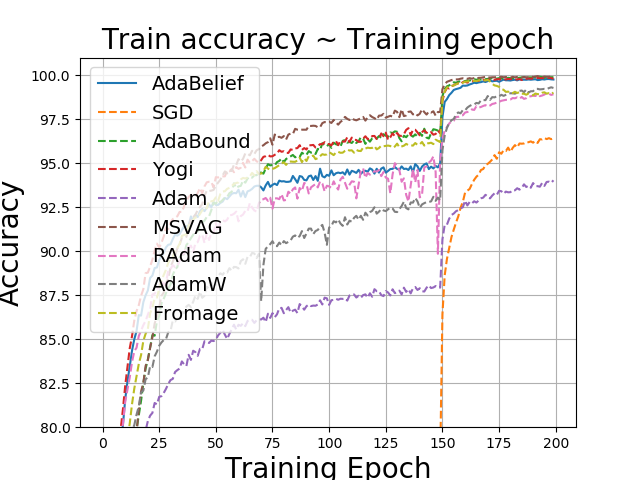

<IPython.core.display.Javascript object>


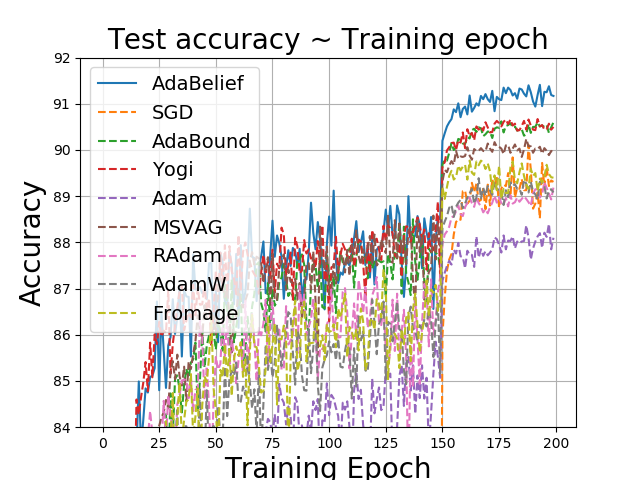

In [50]:
names = ['vgg-adabelief-lr0.001-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse',
         'vgg-sgd-lr0.1-momentum0.9-wdecay0.0005-run0-resetFalse',
         'vgg-adabound-lr0.001-betas0.9-0.999-final_lr0.1-gamma0.001-wdecay0.0005-run0-resetFalse',
         'vgg-yogi-lr0.001-betas0.9-0.999-eps0.001-wdecay0.0005-run0-resetFalse',
         'vgg-adam-lr0.001-betas0.9-0.999-wdecay0.0005-eps1e-08-run0-resetFalse',
         'vgg-msvag-lr0.1-betas0.9-0.999-eps1e-08-wdecay0.0005-run0-resetFalse',
         'vgg-radam-lr0.001-betas0.9-0.999-wdecay0.0005-eps1e-08-run0-resetFalse',
         'vgg-adamw-lr0.001-betas0.9-0.999-wdecay0.01-eps1e-08-run0-resetFalse',
         'vgg-fromage-lr0.01-betas0.9-0.999-wdecay0.0005-eps1e-08-run0-resetFalse',
]
labels = ['AdaBelief',
          'SGD',
          'AdaBound',
          'Yogi',
          'Adam',
          'MSVAG',
          'RAdam',
          'AdamW',
          'Fromage',
        ]
plot(names, 'Train', labels)
plot(names, 'Test', labels, ylim = (84,92))     